# TIGRESS-NCR 21-cm Radiative Transfer
Trey Wenger - October 2024

Performs 21-cm radiative transfer on TIGRESS-NCR data:
* extracts physical conditions from TIGRESS
* saves those data to FITS cubes
* performs 21-cm radiative transfer along a given axis
* saves those data to FITS cubes
* smooths emission cubes
* generates sythetic spectral observations

## Load simulation data

In [1]:
import pyathena as pa

# path to TIGRESS data
dir_master = "/media/drive1/tigress_ncr"
model_id = "R8_4pc"

# load simulation
print("Loading simulation...")
sim = pa.LoadSim(f"{dir_master}/{model_id}").load_vtk(num=300)

[LoadSim-WARNING] Could not find hst file in /media/drive1/tigress_ncr/R8_4pc
[LoadSim-WARNING] zprof files not found in /media/drive1/tigress_ncr/R8_4pc.
[LoadSim-WARNING] rst files not found in /media/drive1/tigress_ncr/R8_4pc.


Loading simulation...


In [2]:
print(sim.domain)

full_data_shape = sim.domain['Nx']
print(full_data_shape)

# keep only z = -638 to +638 pc
le = [-512, -512, -638]
re = [512, 512, 638]
data_shape = [256, 256, 320]
print(data_shape)

{'all_grid_equal': True, 'ngrid': 768, 'le': array([ -512.,  -512., -3072.], dtype=float32), 're': array([ 512.,  512., 3072.], dtype=float32), 'dx': array([4., 4., 4.], dtype=float32), 'Lx': array([1024., 1024., 6144.], dtype=float32), 'center': array([0., 0., 0.], dtype=float32), 'Nx': array([ 256,  256, 1536]), 'ndim': 3, 'time': 300.0002}
[ 256  256 1536]
[256, 256, 320]


In [5]:
import multiprocessing as mp
from multiprocessing.shared_memory import SharedMemory

_PHASE_NAMES = ["All", "CNM", "LNM", "WNM"]

def load_shared_memory(data_shape, output_shape, create=False):
    """
    Create or load shared memory resources for multiprocessing

    Inputs:
        data_shape :: tuple
            Data shape
        output_shape :: tuple
            Radiative transfer output shape
        create :: boolean
            If True, create new shared resources. Otherwise, access existing resources
    """
    data_nbytes = np.prod(data_shape) * 8
    output_nbytes = np.prod(output_shape) * 8

    # storage for all shared memory buffers
    sh_mem = []

    # storage for numpy data that reference shared memory buffers
    data = {}

    # simulation data
    data_vars = ["kin_temp", "spin_temp", "velocity", "sigma"]
    for data_var in data_vars:
        mem = SharedMemory(name=data_var, create=create, size=data_nbytes)
        sh_mem.append(mem)
        data[data_var] = np.ndarray(data_shape, dtype=float, buffer=mem.buf)

    data["nHI"] = {}
    data["NHI"] = {}
    for phase_name in _PHASE_NAMES:
        mem = SharedMemory(name=f"nHI_{phase_name}", create=create, size=data_nbytes)
        sh_mem.append(mem)
        data["nHI"][phase_name] = np.ndarray(data_shape, dtype=float, buffer=mem.buf)
        mem = SharedMemory(name=f"NHI_{phase_name}", create=create, size=output_nbytes)
        sh_mem.append(mem)
        data["NHI"][phase_name] = np.ndarray(output_shape, dtype=float, buffer=mem.buf)

    # radiative transfer outputs
    data_vars = ["TB_on", "TB_off"]
    for data_var in data_vars:
        data[data_var] = {}
        for phase_name in _PHASE_NAMES:
            mem = SharedMemory(
                name=f"{data_var}_{phase_name}", create=create, size=output_nbytes
            )
            sh_mem.append(mem)
            data[data_var][phase_name] = np.ndarray(
                output_shape, dtype=float, buffer=mem.buf
            )

    data_vars = ["TB_mean_temp", "TB_mean_density"]
    for data_var in data_vars:
        mem = SharedMemory(name=data_var, create=create, size=output_nbytes)
        sh_mem.append(mem)
        data[data_var] = np.ndarray(output_shape, dtype=float, buffer=mem.buf)

    return data, sh_mem

In [6]:
import numpy as np

# observed spectral axis
spec_velocity = np.arange(-150.0, 150.5, 0.5)

# shared memory for multiprocessing radiative transfer
print("Initializing shared memory...")
observe_axis = 1 # observe along y-axis
output_shape = (len(spec_velocity),) + tuple(
    [shape for i, shape in enumerate(data_shape) if i != observe_axis]
)
data, sh_mem = load_shared_memory(data_shape, output_shape, create=True)

Initializing shared memory...


## Prepare simulation data

In [46]:
# Extract simulation data
print("Extracting simulation data...")
sim_data = sim.get_field(['nH', 'xe', 'T', 'pressure', 'vy'], le=le, re=re)
data["kin_temp"][:] = sim_data['T'].data.T
nHI = sim_data['nH'].data.T * (1.0 - sim_data['xe'].data.T)
pressure = sim_data['pressure'].data.T
data["velocity"][:] = sim_data['vy'].data.T
xe = sim_data['xe'].data.T

Extracting simulation data...


In [47]:
from astropy.io import fits

outdir = "/media/drive1/tigress_ncr_results/R8_4pc"

# save FITS
print("Saving simulation data...")
hdu = fits.PrimaryHDU(nHI)
hdu.writeto(f"{outdir}/nHI.fits", overwrite=True)
hdu = fits.PrimaryHDU(pressure)
hdu.writeto(f"{outdir}/pressure.fits", overwrite=True)
hdu = fits.PrimaryHDU(data["kin_temp"])
hdu.writeto(f"{outdir}/kinetic_temperature.fits", overwrite=True)
hdu = fits.PrimaryHDU(data["velocity"])
hdu.writeto(f"{outdir}/velocity.fits", overwrite=True)
hdu = fits.PrimaryHDU(xe)
hdu.writeto(f"{outdir}/xe.fits", overwrite=True)

Saving simulation data...


In [48]:
# cell size (square cells)
dx_cm = 1.23427103e+19 # 4 pc

# HI column density
NHI = nHI.sum(axis=observe_axis) * dx_cm
hdu = fits.PrimaryHDU(NHI)
hdu.writeto(f"{outdir}/NHI.fits", overwrite=True)

In [49]:
# HI phase temperature thresholds
print("Clipping HI phases...")
HI_mask = nHI > 0.0
data["mask"] = {}
data["mask"]["All"] = HI_mask.copy()
data["mask"]["CNM"] = HI_mask.copy() * (data["kin_temp"] < 500.0)
data["mask"]["LNM"] = (
    HI_mask.copy() * (data["kin_temp"] > 500.0) * (data["kin_temp"] < 5000.0)
)
data["mask"]["WNM"] = HI_mask.copy() * (data["kin_temp"] > 5000.0)
for phase in _PHASE_NAMES:
    nHI_phase = nHI.copy()
    nHI_phase[~data["mask"][phase]] = 0.0
    data["nHI"][phase][:] = nHI_phase
    NHI_phase = nHI_phase.sum(axis=observe_axis) * dx_cm
    data["NHI"][phase][:] = NHI_phase
    hdu = fits.PrimaryHDU(nHI_phase)
    hdu.writeto(f"{outdir}/nHI_{phase}.fits", overwrite=True)
    hdu = fits.PrimaryHDU(NHI_phase)
    hdu.writeto(f"{outdir}/NHI_{phase}.fits", overwrite=True)

Clipping HI phases...


## Evaluate spin temperature, thermal broadening

In [50]:
def calc_spin_temp(kin_temp, density):
    """
    Calculate the spin temperature following Kim et al. (2014) eq. 4

    Inputs:
        kin_temp :: scalar (K)
            Gas kinetic temperature
        density :: scalar (cm-3)
            Gas density

    Returns:
        spin_temp :: scalar (K)
            Spin temperature
    """
    TR = 3.77  # CMB
    TD = kin_temp
    n_alpha = 1.0e-6  # Lya photon number density cm-3
    y_alpha = 5.9e11 * n_alpha / (TD * np.sqrt(kin_temp))
    T0 = 0.0681  # K
    A10 = 2.8843e-15  # s-1 Einstein A
    k10 = np.zeros_like(kin_temp)
    T2 = kin_temp / 100.0
    k10[kin_temp < 300.0] = 1.19e-10 * T2[kin_temp < 300.0] ** (
        0.74 - 0.20 * np.log(T2[kin_temp < 300.0])
    )
    k10[kin_temp > 300.0] = (
        2.24e-10 * T2[kin_temp > 300.0] ** 0.207 * np.exp(-0.876 / T2[kin_temp > 300.0])
    )
    R10 = density * k10
    y_c = T0 * R10 / (kin_temp * A10)
    spin_temp = (TR + y_c * kin_temp + y_alpha * TD) / (1.0 + y_c + y_alpha)
    return spin_temp

In [51]:
wf = False

# spin temperature
print("Calculating spin temperature...")
if wf:
    data["spin_temp"][:] = data["kin_temp"]
else:
    data["spin_temp"][:] = calc_spin_temp(data["kin_temp"], nHI)
hdu = fits.PrimaryHDU(data["spin_temp"])
hdu.writeto(f"{outdir}/spin_temperature.fits", overwrite=True)

Calculating spin temperature...


In [52]:
# turbulent broadening, assume 2 km/s on 4 pc scales
fwhm_turbulent = 2.0  # km/s

# thermal broadening (km/s)
fwhm_thermal = 21.4 * np.sqrt(data["kin_temp"] / 1.0e4)
hdu = fits.PrimaryHDU(fwhm_thermal)
hdu.writeto(f"{outdir}/fwhm_thermal.fits", overwrite=True)

# line width
fwhm = np.sqrt(fwhm_thermal**2.0 + fwhm_turbulent**2.0)
data["sigma"][:] = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))

# background continuum source
Tbg = 1000.0

## Perform radiative transfer

In [53]:
def simple_slice(arr, inds, axis):
    # this does the same as np.take() except only supports simple slicing, not
    # advanced indexing, and thus is much faster
    # From: https://stackoverflow.com/questions/24398708/slicing-a-numpy-array-along-a-dynamically-specified-axis
    # e.g., simple_slice(arr, 0, 1) == arr[:, 0, :]
    # e.g., simple_slice(arr, slice(1, None), 1) == arr[:, 1:, :]
    sl = [slice(None)] * arr.ndim
    sl[axis] = inds
    return arr[tuple(sl)]

In [54]:
def radiative_transfer(
    idx,
    spec_vel,
    dx_cm,
    Tbg,
    axis,
    data_shape,
    output_shape,
):
    """
    Process the radiative transfer for a single pixel.

    Inputs:
        idx :: integer
            Pixel index
        spec_vel :: 1-D array of scalars
            Spectral velocity axis (km/s)
        dx_cm :: scalar
            Simulation grid resolution (cm)
        Tbg :: scalar
            Background brightness temperature for ON observation (K)
        axis :: integer
            Axis to treat as line-of-sight
        data_shape :: tuple
            Data shape
        output_shape :: tuple
            Radiative transfer output shape

    Returns:
        idx :: integer
            Same as input
    """
    # load shared memory
    (
        data,
        _,
    ) = load_shared_memory(data_shape, output_shape, create=False)

    # radiative transfer constant
    const = 1.82243e18  # cm-2 (K km s-1)-1

    # background CMB + synchrotron
    Tcmb = 3.77  # K

    # line profile
    line_profile = np.exp(
        -0.5 * (data["velocity"] - spec_vel) ** 2.0 / data["sigma"] ** 2.0
    ) / np.sqrt(2.0 * np.pi * data["sigma"] ** 2.0)

    for phase in _PHASE_NAMES:
        # optical depth
        tau = data["nHI"][phase] * dx_cm * line_profile / data["spin_temp"] / const
        sum_tau = np.nancumsum(tau, axis=axis)

        # background
        TB_back_on = (Tcmb + Tbg) * np.exp(-simple_slice(sum_tau, -1, axis))
        TB_back_off = Tcmb * np.exp(-simple_slice(sum_tau, -1, axis))

        # front surface
        TB_front = simple_slice(data["spin_temp"], 0, axis) * (
            1.0 - np.exp(-simple_slice(tau, 0, axis))
        )

        # everything else
        TB_middle = (
            simple_slice(data["spin_temp"], slice(1, None), axis)
            * (1.0 - np.exp(-simple_slice(tau, slice(1, None), axis)))
            * np.exp(-simple_slice(sum_tau, slice(None, -1), axis))
        )

        data["TB_on"][phase][idx] = (
            TB_back_on + np.nansum(TB_middle, axis=axis) + TB_front
        )
        data["TB_off"][phase][idx] = (
            TB_back_off + np.nansum(TB_middle, axis=axis) + TB_front
        )

        if phase == "All":
            # weighted mean kinetic temperature
            TB_front_temp = simple_slice(data["kin_temp"], 0, axis) * TB_front
            TB_middle_temp = np.nansum(
                simple_slice(data["kin_temp"], slice(1, None), axis) * TB_middle,
                axis=axis,
            )
            data["TB_mean_temp"][idx] = (TB_middle_temp + TB_front_temp) / data[
                "TB_off"
            ][phase][idx]

            # weighted mean density
            TB_front_density = simple_slice(data["nHI"][phase], 0, axis) * TB_front
            TB_middle_density = np.nansum(
                simple_slice(data["nHI"][phase], slice(1, None), axis) * TB_middle,
                axis=axis,
            )
            data["TB_mean_density"][idx] = (
                TB_middle_density + TB_front_density
            ) / data["TB_off"][phase][idx]
    return idx

In [55]:
from tqdm.notebook import tqdm
import multiprocessing as mp

num_processes = mp.cpu_count()
print(f"Running {num_processes} parallel processes")

# Track progress
print("Performing radiative transfer...")
pbar = tqdm(total=len(spec_velocity))

def update(result):
    pbar.update()

with mp.Pool(processes=num_processes) as p:
    for idx, spec_vel in enumerate(spec_velocity):
        p.apply_async(
            radiative_transfer,
            args=(
                idx,
                spec_vel,
                dx_cm,
                Tbg,
                observe_axis,
                data_shape,
                output_shape,
            ),
            callback=update,
        )
    p.close()
    p.join()

Running 24 parallel processes
Performing radiative transfer...


  0%|          | 0/601 [00:00<?, ?it/s]

In [56]:
# save FITS
hdu = fits.PrimaryHDU(data["TB_mean_temp"])
hdu.writeto(f"{outdir}/HI_TB_mean_temp.fits", overwrite=True)
hdu = fits.PrimaryHDU(data["TB_mean_density"])
hdu.writeto(f"{outdir}/HI_TB_mean_density.fits", overwrite=True)
for phase in _PHASE_NAMES:
    hdu = fits.PrimaryHDU(data["TB_on"][phase])
    hdu.writeto(f"{outdir}/HI_{phase}_TB_on.fits", overwrite=True)
    hdu = fits.PrimaryHDU(data["TB_off"][phase])
    hdu.writeto(f"{outdir}/HI_{phase}_TB_off.fits", overwrite=True)

In [57]:
# free shared memory
for mem in sh_mem:
    mem.close()
    mem.unlink()

## Plot simulation data

In [58]:
# load data
from astropy.io import fits

with fits.open(f"{outdir}/nHI.fits") as hdulist:
    nHI = hdulist[0].data
with fits.open(f"{outdir}/pressure.fits") as hdulist:
    pressure = hdulist[0].data
with fits.open(f"{outdir}/kinetic_temperature.fits") as hdulist:
    kin_temp = hdulist[0].data
with fits.open(f"{outdir}/spin_temperature.fits") as hdulist:
    spin_temp = hdulist[0].data
with fits.open(f"{outdir}/xe.fits") as hdulist:
    xe = hdulist[0].data

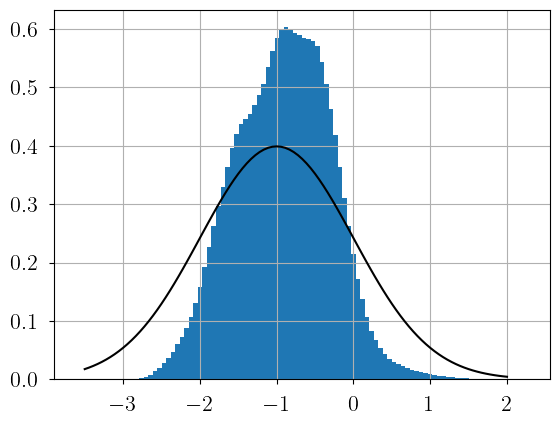

In [85]:
from scipy.stats import norm

_ = plt.hist(np.log10(nHI[HI_mask]).flatten(), bins=100, density=True)
x_pdf = np.linspace(-3.5, 2.0, 100)
y_pdf = norm.pdf(x_pdf, loc=-1.0, scale=1.0)
_ = plt.plot(x_pdf, y_pdf, 'k-')

In [86]:
phases = {
    "All": {"color": "black"},
    "CNM": {"color": "blue"},
    "LNM": {"color": "green"},
    "WNM": {"color": "orange"},
}

# masks
HI_mask = (nHI > 0.0) * (xe < 0.5)
phases["All"]["mask"] = HI_mask
phases["CNM"]["mask"] = HI_mask * (kin_temp < 500.0)
phases["LNM"]["mask"] = HI_mask * (kin_temp > 500.0) * (kin_temp < 5000.0)
phases["WNM"]["mask"] = HI_mask * (kin_temp > 5000.0)
for phase in phases.keys():
    nHI_phase = nHI.copy()
    nHI_phase[~phases[phase]["mask"]] = 0.0
    phases[phase]["nHI"] = nHI_phase

/tmp/ipykernel_974/1459812214.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


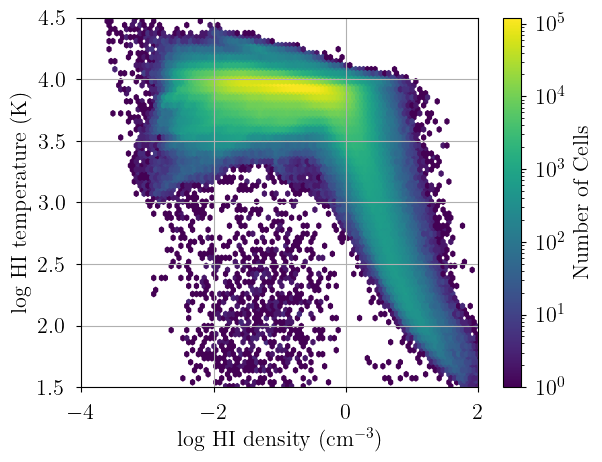

In [87]:
import matplotlib.pyplot as plt

# phase diagram
fig, ax = plt.subplots()
cax = ax.hexbin(
    np.log10(nHI[HI_mask]).flatten(),
    np.log10(kin_temp[HI_mask]).flatten(),
    bins="log",
    mincnt=1,
)
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel(r"log HI density (cm$^{-3}$)")
ax.set_ylabel("log HI temperature (K)")
ax.set_xlim(-4.0, 2.0)
ax.set_ylim(1.5, 4.5)
fig.savefig(f"{outdir}/phase.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_974/2191054242.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


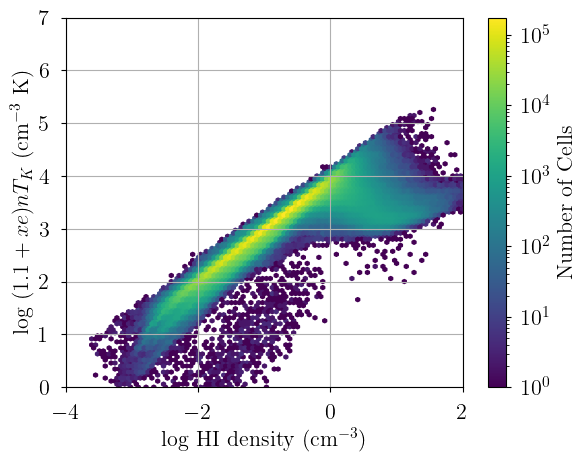

In [89]:
# phase diagram
fig, ax = plt.subplots()
cax = ax.hexbin(
    np.log10(nHI[HI_mask]).flatten(),
    np.log10(1.1 * nHI[HI_mask] * kin_temp[HI_mask]).flatten(),
    bins="log",
    mincnt=1,
)
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel(r"log HI density (cm$^{-3}$)")
ax.set_ylabel(r"log $(1.1 + xe) n T_K$ (cm$^{-3}$ K)")
ax.set_xlim(-4.0, 2.0)
ax.set_ylim(0.0, 7.0)
fig.savefig(f"{outdir}/phase_nT.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_974/3594685604.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


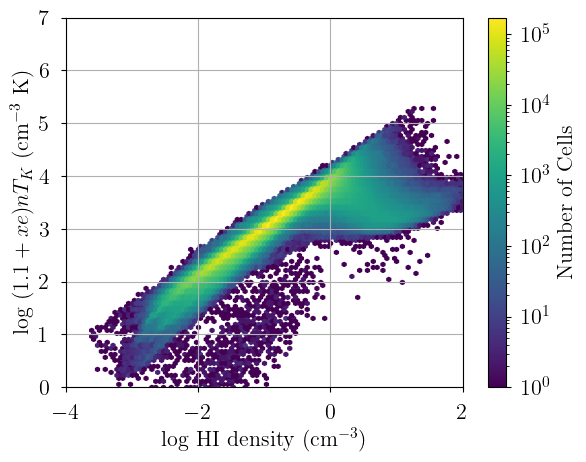

In [90]:
# phase diagram
fig, ax = plt.subplots()
cax = ax.hexbin(
    np.log10(nHI[HI_mask]).flatten(),
    np.log10((1.1 + xe[HI_mask]) * nHI[HI_mask] * kin_temp[HI_mask]).flatten(),
    bins="log",
    mincnt=1,
)
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel(r"log HI density (cm$^{-3}$)")
ax.set_ylabel(r"log $(1.1 + xe) n T_K$ (cm$^{-3}$ K)")
ax.set_xlim(-4.0, 2.0)
ax.set_ylim(0.0, 7.0)
fig.savefig(f"{outdir}/phase_xenT.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_974/1299967833.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


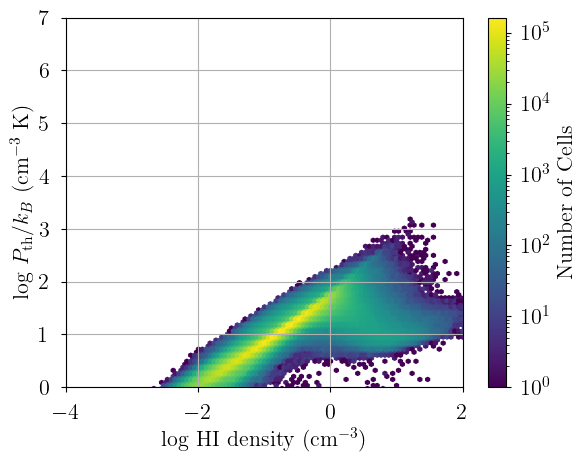

In [91]:
# phase diagram
fig, ax = plt.subplots()
cax = ax.hexbin(
    np.log10(nHI[HI_mask]).flatten(),
    np.log10(pressure[HI_mask]).flatten(),
    bins="log",
    mincnt=1,
)
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel(r"log HI density (cm$^{-3}$)")
ax.set_ylabel(r"log $P_{\rm th}/k_B$ (cm$^{-3}$ K)")
ax.set_xlim(-4.0, 2.0)
ax.set_ylim(0.0, 7.0)
fig.savefig(f"{outdir}/phase_pressure.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_974/397481834.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


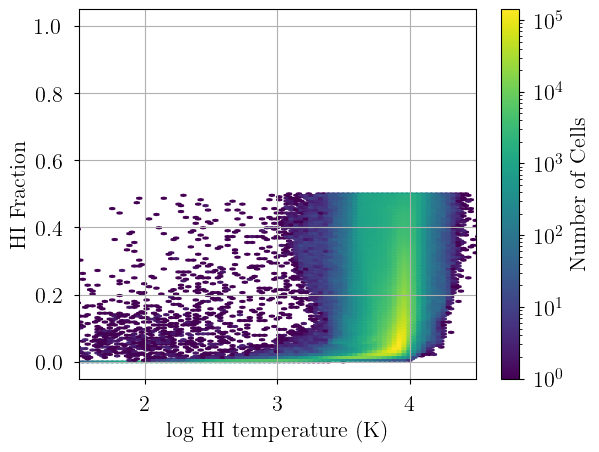

In [92]:
# ionization fraction vs. temperature
fig, ax = plt.subplots()
cax = ax.hexbin(
    np.log10(kin_temp[HI_mask]).flatten(),
    xe[HI_mask].flatten(),
    bins="log",
    mincnt=1,
)
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel("log HI temperature (K)")
ax.set_ylabel("HI Fraction")
ax.set_xlim(1.5, 4.5)
ax.set_ylim(-0.05, 1.05)
fig.savefig(f"{outdir}/xHI_temperature.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_974/209740208.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


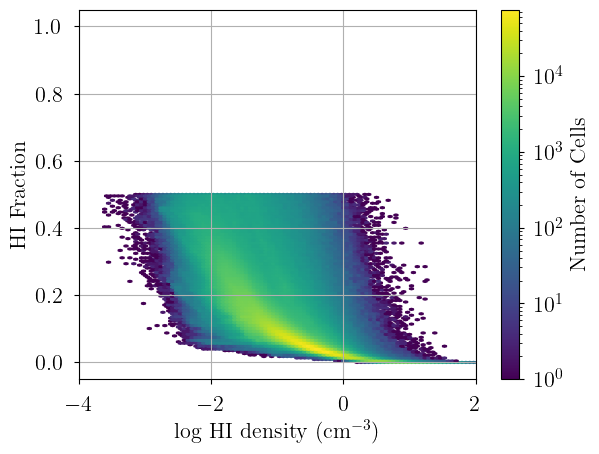

In [93]:
# ionization fraction vs. density
fig, ax = plt.subplots()
cax = ax.hexbin(
    np.log10(nHI[HI_mask]).flatten(),
    xe[HI_mask].flatten(),
    bins="log",
    mincnt=1,
)
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel(r"log HI density (cm$^{-3}$)")
ax.set_ylabel("HI Fraction")
ax.set_xlim(-4.0, 2.0)
ax.set_ylim(-0.05, 1.05)
fig.savefig(f"{outdir}/xHI_density.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_974/2904924696.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


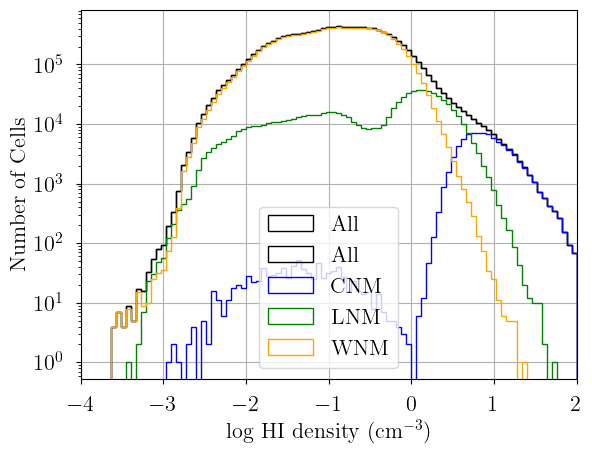

In [94]:
# density histogram
fig, ax = plt.subplots()
bins = np.linspace(-4.0, 2.0, 100)
ax.hist(
    np.log10(nHI[HI_mask]).flatten(),
    bins=bins,
    color="k",
    histtype="step",
    label="All",
)
for phase in phases.keys():
    nHI_phase = phases[phase]["nHI"]
    mask = phases[phase]["mask"]
    ax.hist(
        np.log10(nHI_phase[mask]).flatten(),
        bins=bins,
        color=phases[phase]["color"],
        histtype="step",
        label=phase,
    )
ax.legend(loc="best")
ax.set_yscale("log")
ax.set_xlim(-4.0, 2.0)
ax.set_xlabel(r"log HI density (cm$^{-3}$)")
ax.set_ylabel("Number of Cells")
fig.savefig(f"{outdir}/HI_density_pdf.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_974/2447173173.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


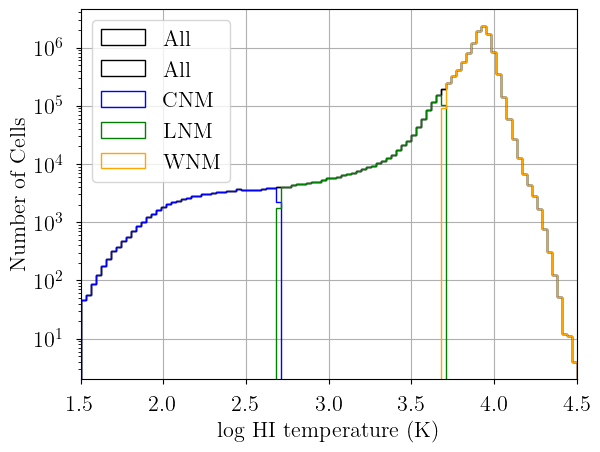

In [95]:
# temperature histogram
fig, ax = plt.subplots()
bins = np.linspace(1.5, 4.5, 100)
ax.hist(
    np.log10(kin_temp[HI_mask]).flatten(),
    bins=bins,
    color="k",
    histtype="step",
    label="All",
)
for phase in phases.keys():
    mask = phases[phase]["mask"]
    ax.hist(
        np.log10(kin_temp[mask]).flatten(),
        bins=bins,
        color=phases[phase]["color"],
        histtype="step",
        label=phase,
    )
ax.legend(loc="best")
ax.set_yscale("log")
ax.set_xlim(1.5, 4.5)
ax.set_xlabel("log HI temperature (K)")
ax.set_ylabel("Number of Cells")
fig.savefig(f"{outdir}/HI_temperature_pdf.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_974/2208281144.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


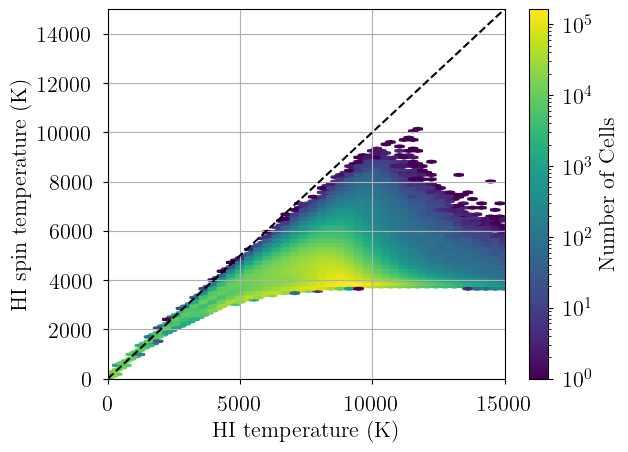

In [96]:
# spin temperature vs. kinetic temperature
fig, ax = plt.subplots()
cax = ax.hexbin(
    kin_temp[HI_mask].flatten(),
    spin_temp[HI_mask].flatten(),
    bins="log",
    mincnt=1,
)
ax.plot([0.0, 15000.0], [0.0, 15000.0], "k--")
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel("HI temperature (K)")
ax.set_ylabel("HI spin temperature (K)")
ax.set_xlim(0.0, 15000.0)
ax.set_ylim(0.0, 15000.0)
fig.savefig(f"{outdir}/HI_spin_temp_temperature.pdf", bbox_inches="tight")
fig.show()

/tmp/ipykernel_974/250444895.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


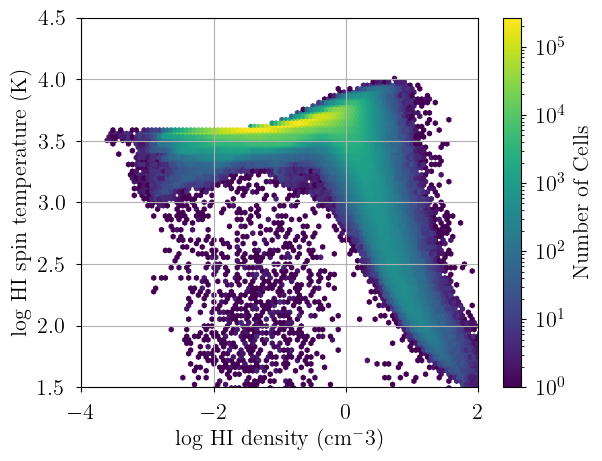

In [98]:
# spin temperature vs. density
fig, ax = plt.subplots()
cax = ax.hexbin(
    np.log10(nHI[HI_mask]).flatten(),
    np.log10(spin_temp[HI_mask]).flatten(),
    bins="log",
    mincnt=1,
)
cbar = fig.colorbar(cax)
cbar.set_label("Number of Cells")
ax.set_xlabel(f"log HI density (cm$^{-3}$)")
ax.set_ylabel("log HI spin temperature (K)")
ax.set_xlim(-4.0, 2.0)
ax.set_ylim(1.5, 4.5)
fig.savefig(f"{outdir}/HI_spin_temp_density.pdf", bbox_inches="tight")
fig.show()

## Smooth data

In [6]:
from scipy.ndimage import gaussian_filter
from astropy.io import fits
import numpy as np

_PHASE_NAMES = ["CNM", "LNM", "WNM", "All"]

outdir = "/media/drive1/tigress_ncr_results/R8_4pc"

# Assumed CMB background brightness temperature
Tcmb = 3.77

# Assumed ON source brightness temperature
Tbg = 1000.0

# Smooth to mimic emission observations
# FWHM = 3 pixels
# FWHM = 10 pixels
for fwhm in [3, 10]:
    print(fwhm)
    sigma = fwhm/(2.0*np.sqrt(2.0*np.log(2.0)))
    for phase in _PHASE_NAMES:
        print(phase)
        # ON source brightness temperature, smoothed along spatial axes
        with fits.open(f"{outdir}/HI_{phase}_TB_on.fits") as hdulist:
            TB_on = hdulist[0].data
        smooth_TB_on = gaussian_filter(TB_on, sigma=sigma, axes=[1, 2], mode="wrap")
        hdu = fits.PrimaryHDU(smooth_TB_on)
        hdu.writeto(f"{outdir}/HI_{phase}_TB_on_smooth_{fwhm}pix.fits", overwrite=True)
    
        # Off source brightness temperature, smoothed along spatial axes
        with fits.open(f"{outdir}/HI_{phase}_TB_off.fits") as hdulist:
            TB_off = hdulist[0].data
        smooth_TB_off = gaussian_filter(TB_off, sigma=sigma, axes=[1, 2], mode="wrap")
        hdu = fits.PrimaryHDU(smooth_TB_off)
        hdu.writeto(f"{outdir}/HI_{phase}_TB_off_smooth_{fwhm}pix.fits", overwrite=True)
        
        # Calculate, save optical depth
        if fwhm == 3:
            # only have to do this once
            tau = -np.log((TB_on - TB_off) / Tbg)
            hdu = fits.PrimaryHDU(tau)
            hdu.writeto(f"{outdir}/HI_{phase}_tau.fits", overwrite=True)

    # column density, smoothed along spatial axes (all axes)
    with fits.open(f"{outdir}/NHI_All.fits") as hdulist:
        data = hdulist[0].data
    smooth_data = gaussian_filter(data, sigma=sigma, mode="wrap")
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/NHI_All_smooth_{fwhm}pix.fits", overwrite=True)
            
    # spin temperature, smoothed along x and z axes
    with fits.open(f"{outdir}/spin_temperature.fits") as hdulist:
        spin_temperature = hdulist[0].data
    smooth_spin_temperature = gaussian_filter(spin_temperature, sigma=sigma, axes=[0, 2], mode="wrap")
    hdu = fits.PrimaryHDU(smooth_spin_temperature)
    hdu.writeto(f"{outdir}/spin_temperature_smooth_{fwhm}pix.fits", overwrite=True)
    
    # density, smoothed along x and z axes
    with fits.open(f"{outdir}/nHI_All.fits") as hdulist:
        density = hdulist[0].data
    smooth_density = gaussian_filter(density, sigma=sigma, axes=[0, 2], mode="wrap")
    hdu = fits.PrimaryHDU(smooth_density)
    hdu.writeto(f"{outdir}/nHI_All_smooth_{fwhm}pix.fits", overwrite=True)
    
    # thermal FWHM, smoothed along x and z axes
    with fits.open(f"{outdir}/fwhm_thermal.fits") as hdulist:
        fwhm_thermal = hdulist[0].data
    smooth_fwhm_thermal = gaussian_filter(fwhm_thermal, sigma=sigma, axes=[0, 2], mode="wrap")
    hdu = fits.PrimaryHDU(smooth_fwhm_thermal)
    hdu.writeto(f"{outdir}/fwhm_thermal_smooth_{fwhm}pix.fits", overwrite=True)
            
    # optical depth and TB weights
    tau_weights = density / spin_temperature / (fwhm_thermal + 2.0) # 2 km/s non-thermal broadening per cell
    TB_weights = density / (fwhm_thermal + 2.0) # optically-thin approx
    print(f"tau_weights nan: {np.sum(np.isnan(tau_weights))}")
    print(f"TB_weights nan: {np.sum(np.isnan(TB_weights))}")
    if fwhm == 3:
        # only need to do this once
        hdu = fits.PrimaryHDU(tau_weights)
        hdu.writeto(f"{outdir}/tau_weights.fits", overwrite=True)
        hdu = fits.PrimaryHDU(TB_weights)
        hdu.writeto(f"{outdir}/TB_weights.fits", overwrite=True)
    
    # weight normalization, smooth along x and z axes
    tau_weights_smooth = gaussian_filter(tau_weights, sigma=sigma, axes=[0, 2], mode="wrap")
    TB_weights_smooth = gaussian_filter(TB_weights, sigma=sigma, axes=[0, 2], mode="wrap")
    is_zero_tau = tau_weights_smooth == 0.0
    is_zero_TB = TB_weights_smooth == 0.0
    print(f"tau_weights_smooth zero: {np.sum(is_zero_tau)}")
    print(f"TB_weights_smooth zero: {np.sum(is_zero_TB)}")
    tau_weights_smooth[is_zero_tau] = 1.0
    TB_weights_smooth[is_zero_TB] = 1.0
    hdu = fits.PrimaryHDU(tau_weights_smooth)
    hdu.writeto(f"{outdir}/tau_weights_smooth_{fwhm}pix.fits", overwrite=True)
    hdu = fits.PrimaryHDU(TB_weights_smooth)
    hdu.writeto(f"{outdir}/TB_weights_smooth_{fwhm}pix.fits", overwrite=True)
    
    # TB-weighted density, smoothed along x and z axes
    smooth_data = gaussian_filter(density * TB_weights, sigma=sigma, axes=[0, 2], mode="wrap") / TB_weights_smooth
    smooth_data[is_zero_TB] = 0.0
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/nHI_All_smooth_{fwhm}pix_TB.fits", overwrite=True)
    
    # tau-weighted density, smoothed along x and z axes
    smooth_data = gaussian_filter(density * tau_weights, sigma=sigma, axes=[0, 2], mode="wrap") / tau_weights_smooth
    smooth_data[is_zero_tau] = 0.0
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/nHI_All_smooth_{fwhm}pix_tau.fits", overwrite=True) 
    
    # TB-weighted spin temperature, smoothed along x and z axes
    smooth_data = gaussian_filter(spin_temperature * TB_weights, sigma=sigma, axes=[0, 2], mode="wrap") / TB_weights_smooth
    smooth_data[is_zero_TB] = 0.0
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/spin_temperature_smooth_{fwhm}pix_TB.fits", overwrite=True)
    
    # tau-weighted spin temperature, smoothed along x and z axes
    smooth_data = gaussian_filter(spin_temperature * tau_weights, sigma=sigma, axes=[0, 2], mode="wrap") / tau_weights_smooth
    smooth_data[is_zero_tau] = 0.0
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/spin_temperature_smooth_{fwhm}pix_tau.fits", overwrite=True)
    
    # TB-weighted thermal FWHM, smoothed along x and z axes
    smooth_data = gaussian_filter(fwhm_thermal * TB_weights, sigma=sigma, axes=[0, 2], mode="wrap") / TB_weights_smooth
    smooth_data[is_zero_TB] = 0.0
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/fwhm_thermal_smooth_{fwhm}pix_TB.fits", overwrite=True)
    
    # tau-weighted thermal FWHM, smoothed along x and z axes
    smooth_data = gaussian_filter(fwhm_thermal * tau_weights, sigma=sigma, axes=[0, 2], mode="wrap") / tau_weights_smooth
    smooth_data[is_zero_tau] = 0.0
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/fwhm_thermal_smooth_{fwhm}pix_tau.fits", overwrite=True)
    
    # velocity, smoothed along x and z axes
    with fits.open(f"{outdir}/velocity.fits") as hdulist:
        data = hdulist[0].data
    smooth_data = gaussian_filter(data, sigma=sigma, axes=[0, 2], mode="wrap")
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/velocity_smooth_{fwhm}pix.fits", overwrite=True)
    
    # TB-weighted velocity, smoothed along x and z axes
    smooth_data = gaussian_filter(data * TB_weights, sigma=sigma, axes=[0, 2], mode="wrap") / TB_weights_smooth
    smooth_data[is_zero_TB] = 0.0
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/velocity_smooth_{fwhm}pix_TB.fits", overwrite=True)
    
    # tau-weighted velocity, smoothed along x and z axes
    smooth_data = gaussian_filter(data * tau_weights, sigma=sigma, axes=[0, 2], mode="wrap") / tau_weights_smooth
    smooth_data[is_zero_tau] = 0.0
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/velocity_smooth_{fwhm}pix_tau.fits", overwrite=True)
    
    # kinetic temperature, smoothed along x and z axes
    with fits.open(f"{outdir}/kinetic_temperature.fits") as hdulist:
        data = hdulist[0].data
    smooth_data = gaussian_filter(data, sigma=sigma, axes=[0, 2], mode="wrap")
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/kinetic_temperature_smooth_{fwhm}pix.fits", overwrite=True)
    
    # TB-weighted velocity, smoothed along x and z axes
    smooth_data = gaussian_filter(data * TB_weights, sigma=sigma, axes=[0, 2], mode="wrap") / TB_weights_smooth
    smooth_data[is_zero_TB] = 0.0
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/kinetic_temperature_smooth_{fwhm}pix_TB.fits", overwrite=True)
    
    # tau-weighted velocity, smoothed along x and z axes
    smooth_data = gaussian_filter(data * tau_weights, sigma=sigma, axes=[0, 2], mode="wrap") / tau_weights_smooth
    smooth_data[is_zero_tau] = 0.0
    hdu = fits.PrimaryHDU(smooth_data)
    hdu.writeto(f"{outdir}/kinetic_temperature_smooth_{fwhm}pix_tau.fits", overwrite=True)

3
CNM
LNM
WNM
All
tau_weights nan: 0
TB_weights nan: 0
tau_weights_smooth zero: 3077670
TB_weights_smooth zero: 3077670
10
CNM
LNM
WNM
All
tau_weights nan: 0
TB_weights nan: 0
tau_weights_smooth zero: 744535
TB_weights_smooth zero: 744535


## Extract spectra

In [8]:
import numpy as np
from astropy.io import fits

rng = np.random.RandomState(seed=1234)
outdir = "/media/drive1/tigress_ncr_results/R8_4pc"

# background CMB + synchrotron
Tcmb = 3.77  # K
# background continuum source
Tbg = 1000.0

# Optical depth rms = 0.001 to mimic 21-SPONGE
# Emission rms = 0.2 K to mimic 21-SPONGE
tau_rms = 0.001
TB_rms = 0.2

# velocity axis
velocity = np.arange(-150.0, 150.1, 0.5)

num_spectra = np.prod(TB_on.shape[1:])
sample_spectra = 1000
sample_idx = rng.choice(np.arange(num_spectra), size=sample_spectra, replace=False)
print(sample_idx[0:10])
print(len(sample_idx))

x_grid, y_grid = np.mgrid[:TB_on.shape[1], :TB_on.shape[2]]
radius = np.sqrt((x_grid-2)**2.0 + (y_grid-2)**2.0)

[27167 56602 74460  5819 62858 77767 10746  2195 38586 65729]
1000


In [9]:
from tqdm.notebook import tqdm
import pickle

# get data
with fits.open(f"{outdir}/HI_All_TB_on.fits") as hdulist:
    TB_on = hdulist[0].data
    
with fits.open(f"{outdir}/HI_All_TB_off.fits") as hdulist:
    TB_off = hdulist[0].data

for fwhm in [1, 3, 10]:
    # Get smoothed data
    if fwhm > 1:
        with fits.open(f"{outdir}/HI_All_TB_on_smooth_{fwhm}pix.fits") as hdulist:
            TB_on_smooth = hdulist[0].data
        with fits.open(f"{outdir}/HI_All_TB_off_smooth_{fwhm}pix.fits") as hdulist:
            TB_off_smooth = hdulist[0].data
    else:
        TB_on_smooth = TB_on
        TB_off_smooth = TB_off

    location = np.ones((sample_spectra, 2)) * np.nan
    
    # N.B. none of these account for the increase in noise due to HI emission
    
    # mismatched spectra
    # pretend we can magically turn off the background continuum source
    # emission is at smoothed FWHM, noise is theoretical
    # absorption is always pencilbeam, noise is theoretical
    # at fwhm = 0, emission and absorption are both pencilbeam
    mismatched_emission_spectra = np.ones((sample_spectra, len(velocity))) * np.nan
    mismatched_absorption_spectra = np.ones((sample_spectra, len(velocity))) * np.nan
    
    # matched spectra
    # there can STILL be emission not seen in absorption, so we should still use the
    # mismatched model to fit these data.
    # simulate single dish or interferometer emission + absorption spectrum
    # following HT03, emission is 2d polynomial fit to annulus [1, sqrt(2)] FWHM
    # emission noise is estimated from std. dev. of residuals in annulus
    # absorption is always pencilbeam, noise is theoretical
    # for single dish, optical depth is derived from emission AND absorption, thus
    # coupling the data. This is beyond the scope of what we are testing
    # I.E. DON'T DO THIS! NEED INDEPENDENT SPECTRA!
    matched_emission_spectra = np.ones((sample_spectra, len(velocity))) * np.nan
    matched_emission_spectra_err = np.ones((sample_spectra, len(velocity))) * np.nan

    # Track progress
    print(f"Extracting spectra (fwhm={fwhm})...")
    pbar = tqdm(total=sample_spectra)
    for i, idx in enumerate(sample_idx):
        x, y = np.unravel_index(idx, TB_off.shape[1:])
        location[i] = np.array([x, y])

        # mismatched absorption spectrum is always pencilbeam
        mismatched_emission_spectra[i] = TB_off_smooth[:, x, y] - Tcmb + TB_rms*rng.randn(len(velocity))
        mismatched_absorption_spectra[i] = 1.0 - (TB_on[:, x, y] - TB_off[:, x, y]) / Tbg + tau_rms*rng.randn(len(velocity))
        
        # annulus [fwhm, 2*fwhm] centered on (x, y)
        x_off = x_grid - x
        y_off = y_grid - y
        radius = np.sqrt(x_off**2.0 + y_off**2.0)
        good_radius = (radius >= fwhm - 0.1) * (radius <= np.sqrt(2.0)*fwhm + 0.1)
        x_good = x_off[good_radius].flatten()
        y_good = y_off[good_radius].flatten()
        if i == 0:
            print(f"fwhm: {fwhm} annulus area: {good_radius.sum()} pixels")
        if fwhm > 1:
            X = np.array([
                np.ones_like(x_good),
                x_good,
                y_good,
                x_good*y_good,
                x_good**2.0,
                y_good**2.0,
                x_good**2.0*y_good,
                x_good*y_good**2.0,
                x_good**2.0*y_good**2.0,
            ]).T
        else:
            X = np.array([
                np.ones_like(x_good),
                x_good,
                y_good,
                x_good*y_good,
            ]).T
        TB_off_good = TB_off_smooth[:, good_radius] - Tcmb
        
        # loop over channels
        for chan in range(TB_off_good.shape[0]):
            TB_off_chan = TB_off_good[chan].flatten()
            
            # least squares
            coeff, sum_res2, rank, s = np.linalg.lstsq(X, TB_off_chan)
            
            # coeff[0] is the centroid prediction
            matched_emission_spectra[i][chan] = coeff[0] + TB_rms*rng.randn()
            
            # estimate residuals
            matched_emission_spectra_err[i][chan] = TB_rms
            if len(sum_res2) > 0:
                matched_emission_spectra_err[i][chan] += np.sqrt(sum_res2[0] / len(TB_off_chan))

        pbar.update()

    # package for gausspy
    mismatched_joint = {
        "data_list": [mismatched_absorption_spectra[i] for i in range(sample_spectra)],
        "data_list_em": [mismatched_emission_spectra[i] for i in range(sample_spectra)],
        "x_values": [velocity for i in range(sample_spectra)],
        "x_values_em": [velocity for i in range(sample_spectra)],
        "errors": [np.ones_like(velocity) * tau_rms for i in range(sample_spectra)],
        "errors_em": [np.ones_like(velocity) * TB_rms for i in range(sample_spectra)],
        "location": [location[i] for i in range(sample_spectra)],
    }
    matched_joint = {
        "data_list": [mismatched_absorption_spectra[i] for i in range(sample_spectra)],
        "data_list_em": [matched_emission_spectra[i] for i in range(sample_spectra)],
        "x_values": [velocity for i in range(sample_spectra)],
        "x_values_em": [velocity for i in range(sample_spectra)],
        "errors": [np.ones_like(velocity) * tau_rms for i in range(sample_spectra)],
        "errors_em": [matched_emission_spectra_err[i] for i in range(sample_spectra)],
        "location": [location[i] for i in range(sample_spectra)],
    }
    with open(f"{outdir}/HI_mismatched_spectra_{fwhm}pix.pkl", "wb") as f:
        pickle.dump(mismatched_joint, f)
    with open(f"{outdir}/HI_matched_spectra_{fwhm}pix.pkl", "wb") as f:
        pickle.dump(matched_joint, f)

Extracting spectra (fwhm=1)...


  0%|          | 0/1000 [00:00<?, ?it/s]

fwhm: 1 annulus area: 8 pixels


/tmp/ipykernel_131346/2200677594.py:91: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff, sum_res2, rank, s = np.linalg.lstsq(X, TB_off_chan)


Extracting spectra (fwhm=3)...


  0%|          | 0/1000 [00:00<?, ?it/s]

fwhm: 3 annulus area: 36 pixels
Extracting spectra (fwhm=10)...


  0%|          | 0/1000 [00:00<?, ?it/s]

fwhm: 10 annulus area: 336 pixels


In [15]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

outdir = "/media/drive1/tigress_ncr_results/R8_4pc"

fwhm = 3
with open(f"{outdir}/HI_mismatched_spectra_1pix.pkl", "rb") as f:
    true_joint = pickle.load(f)
with open(f"{outdir}/HI_mismatched_spectra_{fwhm}pix.pkl", "rb") as f:
    mismatched_joint = pickle.load(f)
with open(f"{outdir}/HI_matched_spectra_{fwhm}pix.pkl", "rb") as f:
    matched_joint = pickle.load(f)

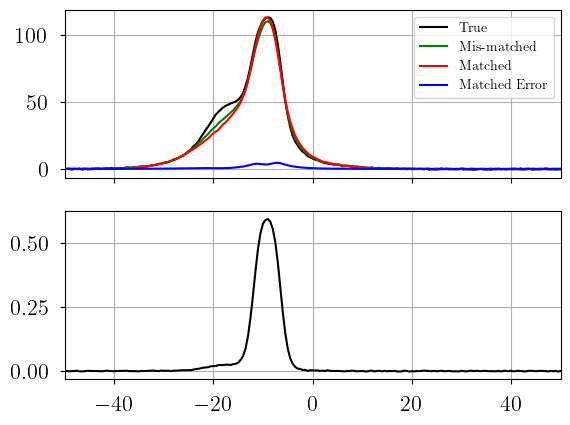

In [27]:
# plot some example spectra
fig, axes = plt.subplots(2, sharex=True)
idx = np.random.choice(len(true_joint['location']))
while np.max(true_joint['data_list'][idx]) < 0.01:
    idx = np.random.choice(len(true_joint['location']))
axes[0].plot(true_joint['x_values_em'][idx], true_joint['data_list_em'][idx], 'k-', label="True")
axes[0].plot(mismatched_joint['x_values_em'][idx], mismatched_joint['data_list_em'][idx], 'g-', label="Mis-matched")
axes[0].plot(matched_joint['x_values_em'][idx], matched_joint['data_list_em'][idx], 'r-', label="Matched")
axes[0].plot(matched_joint['x_values_em'][idx], matched_joint['errors_em'][idx], 'b-', label="Matched Error")
axes[1].plot(true_joint['x_values'][idx], true_joint['data_list'][idx], 'k-')
axes[0].legend(loc='best', fontsize=10)
axes[0].set_xlim(-50.0, 50.0)
fig.show()